Učitavanje potrebnih biblioteka

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
import cv2
import os
import seaborn as sn

from sklearn.metrics import confusion_matrix

## Predobrada slike

Pre izdvajanja karakteristika potrebno je obraditi sliku. Prvo je izvršeno zamućivanje radi otklanjanja naglih ivica, a zatim primenjena dilatacije kojom su uvećani objekti i uklonjeni mali razmaci između prstiju (dok je šaka zatvorena na primer), kako bi se kasnije izdvojila konzistentna celina. Zatim je primenjena erozija kako bi se oblik vratio na prethodne dimenzije, a slika je prema boji binarizovana - svi pikseli koji su imali bilo kakvu koncentraciju zelene su postali crni, ostali su postali beli.

In [10]:
def preprocessing(picture) -> np.ndarray:
    """Zamucivanje i binarizacija slike"""

    # zamucivanje slike
    picture = cv2.GaussianBlur(picture, (11,11), 0)
    # dilatacija slike
    kernel = np.ones((5,5), np.uint8)
    picture = cv2.dilate(picture, kernel, iterations=3)
    # erozija slike
    picture = cv2.erode(picture, kernel, iterations=3)

    # binarizacija slike po boji
    return np.where((picture[:,:,0] < 0.5) & (picture[:,:,1] > 0.1) & (picture[:,:,2] < 0.5), 0, 1)

Primer slika pre i posle preprocesiranja.

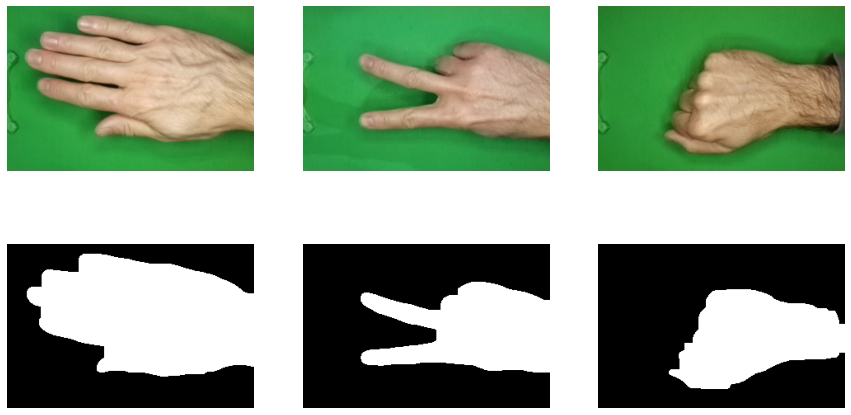

In [11]:
slika_1, slika_2, slika_3 = plt.imread('test1.png'), plt.imread('test2.png'), plt.imread('test3.png')   # ucitavanje primera slika

obradjena_slika_1, obradjena_slika_2, obradjena_slika_3 = preprocessing(slika_1), preprocessing(slika_2), preprocessing(slika_3)   # obrada slika

fig, axs = plt.subplots(2, 3, figsize=(15, 8))  # prikaz slika
axs[0,0].imshow(slika_1), axs[0,1].imshow(slika_2), axs[0,2].imshow(slika_3)
axs[1,0].imshow(obradjena_slika_1, cmap='gray'), axs[1,1].imshow(obradjena_slika_2, cmap='gray'), axs[1,2].imshow(obradjena_slika_3, cmap='gray')

axs[0,0].axis('off'), axs[0,1].axis('off'), axs[0,2].axis('off'), axs[1,0].axis('off'), axs[1,1].axis('off'), axs[1,2].axis('off')  # uklanjanje oznaka osa

plt.show()

## Izvlačenje karakterističnih obeležja

Prvih 9 karakteristika [0-8] predstavlja broj promena vrednosti piksela u različitim kolonama slike. Kolone koje su se posmatrale su uzastopno udaljene za 1/10 dužine slike.

In [12]:
def feature1(picture) -> list:
    """Vraca broj promena vrednosti piksela po x osi na 9 razlicitih mesta"""

    len_x, len_y = picture.shape # duzina i sirina slike
    # 9 pozicija na kojima se racuna broj promena vrednosti piksela
    positions = [len_x//10, 2*len_x//10, 3*len_x//10, 4*len_x//10, 5*len_x//10, 6*len_x//10, 7*len_x//10, 8*len_x//10, 9*len_x//10]
    changes = [] # lista promena vrednosti piksela za svaku poziciju

    for i in positions:
        column = picture[i,:]                 # izdvajanje kolone 
        crosses = 0
        for j in range(1, len(column)):       # brojanje promena vrednosti piksela
            if column[j] != column[j-1]:
                crosses += 1
        changes.append(crosses)               # dodavanje broja promena u listu

    return changes

Narednih 9 karakteristika [9-17] predstavlja broj promena vrednosti piksela u različitim vrstama slike. Vrste koje su se posmatrale su uzastopno udaljene za 1/10 širine slike.

In [13]:
def feature2(picture) -> list:
    """Vraca broj promena vrednosti piksela po y osi na 9 razlicitih mesta"""
    
    len_x, len_y = picture.shape # duzina i sirina slike
    # 9 pozicija na kojima se racuna broj promena vrednosti piksela
    positions = [len_y//10, 2*len_y//10, 3*len_y//10, 4*len_y//10, 5*len_y//10, 6*len_y//10, 7*len_y//10, 8*len_y//10, 9*len_y//10]
    changes = [] # lista promena vrednosti piksela za svaku poziciju

    for i in positions:                    
        column = picture[:,i]               # izdvajanje vrste
        crosses = 0
        for j in range(1, len(column)):     # brojanje promena vrednosti piksela
            if column[j] != column[j-1]:
                crosses += 1
        changes.append(crosses)             # dodavanje broja promena u listu

    return changes

Treća funkcija predstavlja 18-tu karakteristiku, koja određuje odnos broja belih i svih piksela na slici (udeo belih piksela u celoj slici).

In [14]:
def feature3(picture) -> int:
    """Vraca udeo belih piksela u slici"""

    return sum(sum(picture)) / (len(picture)*len(picture[:,0]))

Četvrta funkcija pronalazi cenar mase belih piksela i određuje maksimalnu udaljenost belog piksela od datog centra mase, standardnu devijaciju udaljenosti i srednju vrednost istih.

In [15]:
def feature4(picture) -> list:
    """Vraca maksimalnu vrednost, standardnu devijaciju u srednju vrednost udaljenosti belih piksela od centra mase slike"""

    mass_x = int(np.mean(list(list(np.where(picture == 1))[0]))) # x koordinata centra mase
    mass_y = int(np.mean(list(list(np.where(picture == 1))[1]))) # y koordinata centra mase

    # udaljenost svakog belog piksela od centra mase
    distances = np.sqrt((np.where(picture == 1)[0] - mass_x)**2 + (np.where(picture == 1)[1] - mass_y)**2)/sum(sum(picture)) 

    return [max(distances), np.std(distances), np.mean(distances)]

Peta funkcija vraća udeo belih piksela u levoj i desnoj polovini slike.

In [16]:
def feature5(picture) -> list:
    """Vraca udeo belih piksela u 2 segmenta slike"""

    len_x, len_y = picture.shape        # duzina i sirina slike
    segment1 = picture[:, :len_y//2]    # levi segment slike
    segment2 = picture[:, len_y//2:]    # desni segment slike

    return [sum(sum(segment1)) / (len(segment1)*len(segment1[:,0])), sum(sum(segment2)) / (len(segment2)*len(segment2[:,0]))]

Funkcija find_features primenjuje sve prethodne i vraća listu svih karakteristika. 

In [17]:
def find_features(path) -> list:
    """Vraca listu svih karakteristika"""

    pic = plt.imread(path)              # ucitavanje slike
    pic_bin = preprocessing(pic)        # obrada slike
    
    features = feature1(pic_bin)        # izvlacenje prvih 9 karakteristika
    features.extend(feature2(pic_bin))  # izvlacenje drugih 9 karakteristika
    features.append(feature3(pic_bin))  # izvlacenje 18te karakteristike
    features.extend(feature4(pic_bin))  # izvlacenje pretposlednje 3 karakteristike
    features.extend(feature5(pic_bin))  # izvlacenje poslednjih 5 karakteristika

    return features

## Učitavanje i podela podataka na trening i test skup

In [18]:
def train_test(rock, paper, scissors, perc = 0.8):
    """Podela podataka na trening i test skup"""

    random.shuffle(rock), random.shuffle(paper), random.shuffle(scissors) # mesanje podataka

    rock_train, rock_test = rock[:int(len(rock)*perc)], rock[int(len(rock)*perc):]                          # podela kamena na trening i test skup
    paper_train, paper_test = paper[:int(len(paper)*perc)], paper[int(len(paper)*perc):]                    # podela papira na trening i test skup              
    scissors_train, scissors_test = scissors[:int(len(scissors)*perc)], scissors[int(len(scissors)*perc):]  # podela makaza na trening i test skup

    train_set = rock_train + paper_train + scissors_train   # trening skup
    test_set = rock_test + paper_test + scissors_test       # test skup

    random.shuffle(train_set), random.shuffle(test_set)     # mesanje trening i test skupa

    train_data = np.array([x[0] for x in train_set])        # izdvajanje trening podataka
    train_labels = np.array([x[1] for x in train_set])      # izdvajanje labela za trening
    test_data = np.array([x[0] for x in test_set])          # izdvajanje test podataka
    test_labels = np.array([x[1] for x in test_set])        # izdvajanje labela za test

    return train_data, train_labels, test_data, test_labels

Učitavanje podataka iz baze.

In [19]:
rootdir = 'C:/Users/Zephyrus/Marija/fakultet/4.7.PO/Rock Paper Scissors' # putanja do foldera sa slikama
rock, paper, scissors = [], [], []                                       # liste za kamen, papir i makaze 

for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        label = subdir.split('\\')[-1]

        feature = find_features(os.path.join(subdir, file))              # izvlacenje karakteristika slike

        if label == 'rock':
            rock.append([feature, 0])                                    # ukoliko je kamen, labela je 0
        elif label == 'paper':
            paper.append([feature, 1])                                   # ukoliko je papir, labela je 1
        else:
            scissors.append([feature, 2])                                # ukoliko su makaze, labela je 2

## Analiza karakteristika

In [20]:
# podela podataka na trening i test skup
train_data, train_labels, test_data, test_labels = train_test(rock, paper, scissors)

# formiranje dataframe-a za korelacionu analizu karakteristika
df1 = pd.DataFrame(train_data)
df2 = pd.DataFrame(test_data)
df = pd.concat([df1, df2])

# dodavanje labela u dataframe
df['label'] = np.concatenate((train_labels, test_labels))

df # prikaz

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,label
0,0.0,0.0,4.0,2.0,1.0,1.0,3.0,0.0,0.0,0.0,...,2.0,2.0,2.0,0.419250,0.006765,0.001385,0.003173,0.070525,0.348725,1
1,0.0,2.0,2.0,1.0,1.0,1.0,1.0,2.0,0.0,0.0,...,2.0,2.0,2.0,0.627525,0.005589,0.001195,0.002660,0.230825,0.396700,1
2,0.0,0.0,1.0,1.0,1.0,1.0,2.0,2.0,0.0,0.0,...,2.0,2.0,2.0,0.419775,0.007756,0.001622,0.003384,0.074425,0.345350,2
3,0.0,0.0,4.0,1.0,2.0,3.0,3.0,0.0,0.0,0.0,...,2.0,2.0,2.0,0.327150,0.010372,0.002166,0.004156,0.055175,0.271975,2
4,0.0,0.0,0.0,1.0,1.0,1.0,1.0,4.0,2.0,0.0,...,1.0,2.0,2.0,0.463525,0.006235,0.001282,0.003006,0.080075,0.383450,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
422,0.0,2.0,3.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,...,2.0,2.0,2.0,0.402975,0.008970,0.001936,0.003680,0.097525,0.305450,2
423,0.0,0.0,1.0,1.0,1.0,2.0,2.0,2.0,0.0,0.0,...,2.0,2.0,2.0,0.512550,0.006505,0.001411,0.003084,0.207525,0.305025,0
424,0.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,0.0,...,2.0,2.0,2.0,0.407250,0.007162,0.001372,0.003213,0.010650,0.396600,0
425,0.0,0.0,2.0,2.0,1.0,1.0,3.0,2.0,0.0,0.0,...,2.0,2.0,2.0,0.405250,0.006954,0.001491,0.003315,0.089100,0.316150,0


In [21]:
corr_analysis = abs(df.corr()['label']).sort_values(ascending=False)    # korelacija karakteristika sa labelama
corr_analysis = corr_analysis[corr_analysis.index != 'label']
corr_analysis = corr_analysis[corr_analysis > 0.17]                     # karakteristike sa korelacijom vecom od 0.17 (ovaj prag odredjen je eksperimentalno)
corr_indexes = list(corr_analysis.index)
corr_indexes

[20, 11, 19, 12, 13, 10, 21, 14, 7, 15, 23]

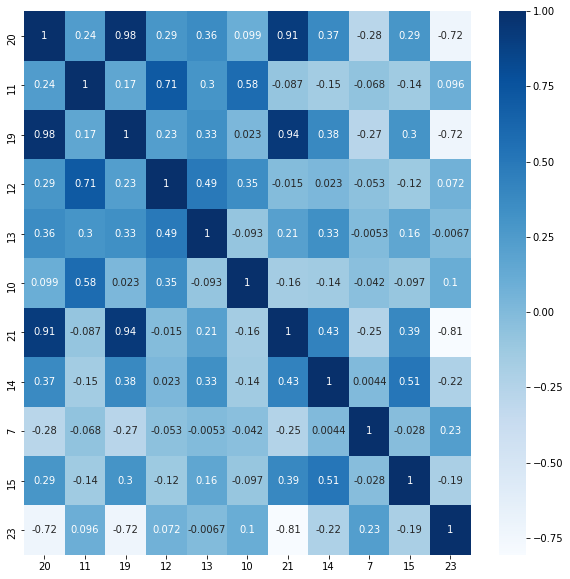

In [22]:
# posmatranje medjusobne korelacije karakteristika
corr = df[corr_indexes].corr()
plt.figure(figsize=(10,10))
sn.heatmap(corr, annot=True, cmap='Blues')
plt.show()

## Klasifikacija

Bajesov test minimalne verovatnoće greške

In [228]:
def testing_hypothesis(train_data, train_labels, test_data, test_labels, chosen_features = corr_indexes): 
    """Metoda testiranja hipoteza"""

    train_data = train_data[:, chosen_features]         # izdvajanje karakteristika koje ce biti koriscene za klasifikaciju
    test_data = test_data[:, chosen_features]           # izdvajanje karakteristika koje ce biti koriscene za klasifikaciju
    
    exp_avg1 = np.mean(train_data[train_labels == 0], axis=0)   # Ek - ovekivanje za kamen
    cov1 = np.cov(train_data[train_labels == 0].T)              # Sk - kovarijaciona matrica za kamen
    exp_avg2 = np.mean(train_data[train_labels == 1], axis=0)   # Ep - ovekivanje za papir
    cov2 = np.cov(train_data[train_labels == 1].T)              # Sp - kovarijaciona matrica za papir
    exp_avg3 = np.mean(train_data[train_labels == 2], axis=0)   # Em - ovekivanje za makaze
    cov3 = np.cov(train_data[train_labels == 2].T)              # Sm - kovarijaciona matrica za makaze

    p1 = len(train_data[train_labels == 0]) / len(train_data)   # verovatnoca kamena 
    p2 = len(train_data[train_labels == 1]) / len(train_data)   # verovatnoca papira
    p3 = len(train_data[train_labels == 2]) / len(train_data)   # verovatnoca makaza

    f1 = lambda x: 1 / np.sqrt((2*np.pi)**2 * np.linalg.det(cov1)) * np.exp(-0.5 * (x - exp_avg1).T @ np.linalg.inv(cov1) @ (x - exp_avg1)) # fgv za kamen
    f2 = lambda x: 1 / np.sqrt((2*np.pi)**2 * np.linalg.det(cov2)) * np.exp(-0.5 * (x - exp_avg2).T @ np.linalg.inv(cov2) @ (x - exp_avg2)) # fgv za papir
    f3 = lambda x: 1 / np.sqrt((2*np.pi)**2 * np.linalg.det(cov3)) * np.exp(-0.5 * (x - exp_avg3).T @ np.linalg.inv(cov3) @ (x - exp_avg3)) # fgv za makaze

    predicted = []  # predvidjene labele
    for x in test_data:     
        if p1*f1(x) > p2*f2(x) and p1*f1(x) > p3*f3(x):     
            predicted.append(0)
        elif p2*f2(x) > p1*f1(x) and p2*f2(x) > p3*f3(x):
            predicted.append(1)
        else:
            predicted.append(2)

    # racunanje tacnosti i matrice konfuzije
    return sum(predicted == test_labels) / len(test_labels), confusion_matrix(test_labels, predicted)

In [229]:
num_of_folds = 20         # broj ponavljanja
accs, matrices = [], []   # liste za cuvanje tacnosti i matrica konfuzije

for i in range(num_of_folds):
    train_data, train_labels, test_data, test_labels = train_test(rock, paper, scissors)
    acc, conf = testing_hypothesis(train_data, train_labels, test_data, test_labels)
    accs.append(acc)
    matrices.append(conf)

Accuracy:  92.25 %
Standard deviation:  1.01 %
Max accuracy:  94.15 %
Confusion matrix: 


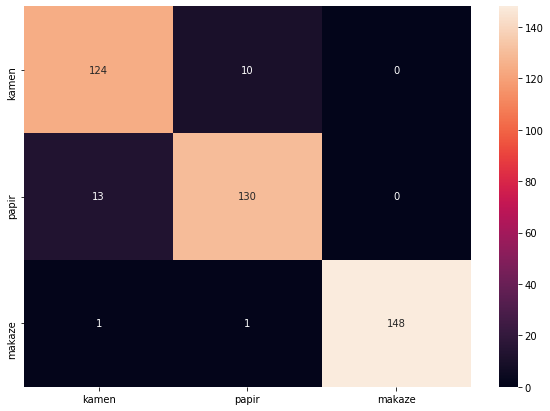

In [230]:
# prikaz prosecne tacnosti i standardne devijacije
print("Accuracy: ", round(np.mean(accs)*100, 2), "%")
print("Standard deviation: ", round(np.std(accs)*100, 2), "%")

# prikaz najvece tacnosti i date matrice konfuzije
max_acc = np.argmax(accs)
print("Max accuracy: ", round(accs[max_acc]*100, 2), "%")

# prikaz matrice konfuzije sa celim prikazom brojeva
print("Confusion matrix: ")
df_cm = pd.DataFrame(matrices[max_acc], index = [i for i in ['kamen', 'papir', 'makaze']],
                    columns = [i for i in ['kamen', 'papir', 'makaze']])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='g')
plt.show()

## Separabilnost dva znaka pomoću dve karakteristike

#### Izbor dva znaka i dve karakteristike

Isprobavanjem različitih kombinacija karakteristika, zaključeno je da kombinacija (11, 19) daje najveću tačnost, a posmatranjem korelacione matrice iz prethodne analize, vidi se da su te dve karakteristike veoma malo korelisane.

In [233]:
num_of_folds = 20         # broj ponavljanja
accs, matrices = [], []   # liste za cuvanje tacnosti i matrica konfuzije

for i in range(num_of_folds):
    train_data, train_labels, test_data, test_labels = train_test(rock, paper, scissors)
    acc, conf = testing_hypothesis(train_data, train_labels, test_data, test_labels, chosen_features = [11, 19])
    accs.append(acc)
    matrices.append(conf)

Accuracy:  86.8 %
Standard deviation:  1.28 %
Max accuracy:  88.99 %
Confusion matrix: 


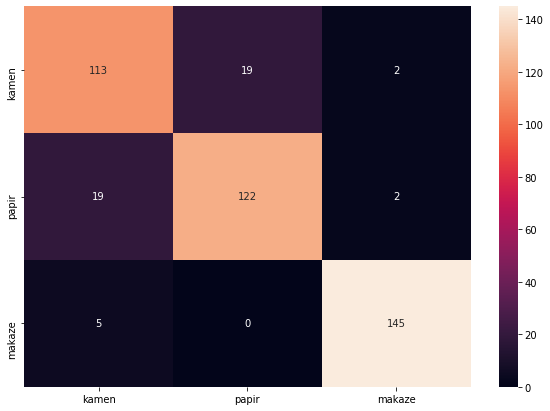

In [234]:
# prikaz prosecne tacnosti i standardne devijacije
print("Accuracy: ", round(np.mean(accs)*100, 2), "%")
print("Standard deviation: ", round(np.std(accs)*100, 2), "%")

# prikaz najvece tacnosti i date matrice konfuzije
max_acc = np.argmax(accs)
print("Max accuracy: ", round(accs[max_acc]*100, 2), "%")

# prikaz matrice konfuzije sa celim prikazom brojeva
print("Confusion matrix: ")
df_cm = pd.DataFrame(matrices[max_acc], index = [i for i in ['kamen', 'papir', 'makaze']],
                    columns = [i for i in ['kamen', 'papir', 'makaze']])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='g')
plt.show()

Iz korelacione matrice se uočava da se najmanje mešaju papir i makaze, pa će baš ta dva elementa biti izabrana za kasniju analizu.

#### Prikaz histograma obeležja za oba znaka

Izabrana su obeležja 11 i 19, kao i znakovi papir i makaze. Prisetimo se da obeležje 11 predstavlja broj nailaska treće po redu vertikalne linije na promenu vrednosti piksela, dok obeležje 19 predstavlja maksimalnu udaljenost belog piksela od centra mase svih belih piksela na slici.

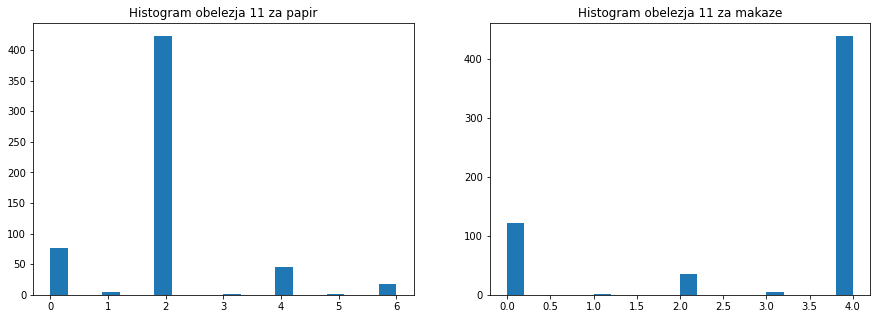

In [238]:
# prikaz histograma obelezja 11
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.hist(train_data[train_labels == 1][:,11], bins=20)
plt.title('Histogram obelezja 11 za papir')
plt.subplot(1, 2, 2)
plt.hist(train_data[train_labels == 2][:,11], bins=20)
plt.title('Histogram obelezja 11 za makaze')
plt.show()


Posmatranjem histograma 11-ste karakteristike za papir i makaze, uočava se da kod slike papira najčešće nailazimo 2 puta na promenu vrednosti piksela. Slično tome, kod makaza se uglavnom nailazi četiri puta (dva ulaza i dva izlaza iz grupacije belih piksela). Vrednosti 4 i 6 kod papira postoje ako su neki od prstiju rašireni, dok se vrednost 0 javlja kada se papir nalazi na ivici slike.

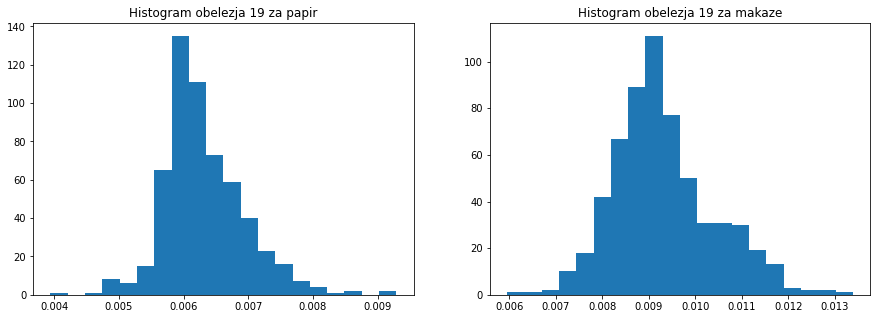

In [239]:
# prikaz histograma obelezja 19
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.hist(train_data[train_labels == 1][:,19], bins=20)
plt.title('Histogram obelezja 19 za papir')
plt.subplot(1, 2, 2)
plt.hist(train_data[train_labels == 2][:,19], bins=20)
plt.title('Histogram obelezja 19 za makaze')
plt.show()

Posmatranjem histograma 19-te karakteristike za papir i makaze, uočava se da je največa koncentracija odbiraka redom oko 0.006 za papir i 0.009 vrednosti za papir. Iako ovi histogrami imaju sličan oblik i deo njihovih odbiraka se preklapa, može se izvesti zaključak da ova karakteristika i dalje pruža dovoljno dobru separabilnost (zbog velikog broja odbiraka koji je skoncentrisan na različitim mestima kod oba histograma).

## Projektovanje parametarskog klasifikatora

In [259]:
# funkcija za formiranje trening i test skupa za binarnu klasifikaciju
def train_test_2(paper, scissors, perc = 0.8):    
    """Podela podataka na trening i test skup"""

    random.shuffle(paper), random.shuffle(scissors) # mesanje podataka

    paper_train, paper_test = paper[:int(len(paper)*perc)], paper[int(len(paper)*perc):]                                      # podela papira na trening i test skup
    scissors_train, scissors_test = scissors[:int(len(scissors)*perc)], scissors[int(len(scissors)*perc):]                    # podela makaza na trening i test skup              

    train_set = paper_train + scissors_train   # trening skup
    test_set = paper_test + scissors_test      # test skup

    random.shuffle(train_set), random.shuffle(test_set)     # mesanje trening i test skupa

    train_data = np.array([x[0] for x in train_set])        # izdvajanje trening podataka
    train_labels = np.array([x[1] for x in train_set])      # izdvajanje labela za trening
    test_data = np.array([x[0] for x in test_set])          # izdvajanje test podataka
    test_labels = np.array([x[1] for x in test_set])        # izdvajanje labela za test

    return train_data, train_labels, test_data, test_labels

Za parametarski klasifikator izabran je linearni klasifikator na bazi željenog izlaza.

In [275]:
def linear_classifier(train_data, train_labels, test_data, test_labels):
    """Linearni klasifikator na bazi zeljenog izlaza"""

    train_data = np.concatenate((train_data, np.ones((len(train_data), 1))), axis=1) # dodavanje kolone jedinica
    test_data = np.concatenate((test_data, np.ones((len(test_data), 1))), axis=1)    # dodavanje kolone jedinica

    #change train and test labels to -1 and 1
    train_labels[train_labels == 2] = -1

    W = np.linalg.inv(train_data.T @ train_data) @ train_data.T @ train_labels       # W = (X^T * X)^-1 * X^T * y

    results = test_data @ W                                                          # rezultati klasifikacije

    predicted = np.where(results > 0, 1, 2)                                          # predvidjene labele
    train_labels[train_labels == -1] = 2                                             # vracanje labela na 1 i 2

    # racunanje tacnosti i matrice konfuzije
    return sum(predicted == test_labels) / len(test_labels), confusion_matrix(test_labels, predicted), W
    

In [276]:
num_of_folds = 20           # broj ponavljanja
accs, matrices = [], []     # liste za cuvanje tacnosti i matrica konfuzije
chosen_features = [11, 19]  # indeksi obelezja koja ce biti koriscena za klasifikaciju
Ws = []                     # lista za cuvanje tezina
data_for_plotting = []      # lista za cuvanje trening i test skupa

for i in range(num_of_folds):
    trd, trl, ted, tel = train_test_2(paper, scissors)          # podela podataka na trening i test skup

    trd = trd[:, chosen_features]                               # izdvajanje obelezja koja ce biti koriscena za klasifikaciju
    ted = ted[:, chosen_features]                               # izdvajanje obelezja koja ce biti koriscena za klasifikaciju

    acc, conf, W = linear_classifier(trd, trl, ted, tel)        # klasifikacija

    # cuvanje rezultata
    accs.append(acc)                                    
    matrices.append(conf)
    Ws.append(W)
    data_for_plotting.append([trd, trl, ted, tel])

Accuracy:  97.18 %
Standard deviation:  0.7 %
Max accuracy:  98.63 %
Confusion matrix: 


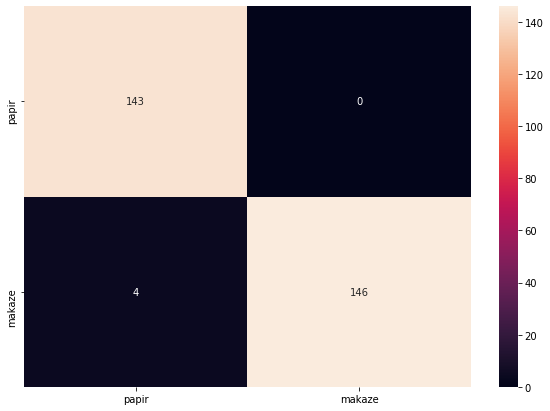

In [277]:
# prikaz prosecne tacnosti i standardne devijacije
print("Accuracy: ", round(np.mean(accs)*100, 2), "%")
print("Standard deviation: ", round(np.std(accs)*100, 2), "%")

# prikaz najvece tacnosti i date matrice konfuzije
max_acc = np.argmax(accs)
print("Max accuracy: ", round(accs[max_acc]*100, 2), "%")

# prikaz matrice konfuzije sa celim prikazom brojeva
print("Confusion matrix: ")
df_cm = pd.DataFrame(matrices[max_acc], index = [i for i in ['papir', 'makaze']],
                    columns = [i for i in ['papir', 'makaze']])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='g')
plt.show()

Posmatranjem matrice konfuzije primećuje se da se sličan broj odbiraka meša imeđu dve izabrane klase.

In [279]:
# parametri za prikazivanje (iteracija sa najvecom tacnoscu)
trd = data_for_plotting[max_acc][0]
trl = data_for_plotting[max_acc][1]
ted = data_for_plotting[max_acc][2]
tel = data_for_plotting[max_acc][3]
w_0 = Ws[max_acc][2]
w_1 = Ws[max_acc][1]
w_2 = Ws[max_acc][0]

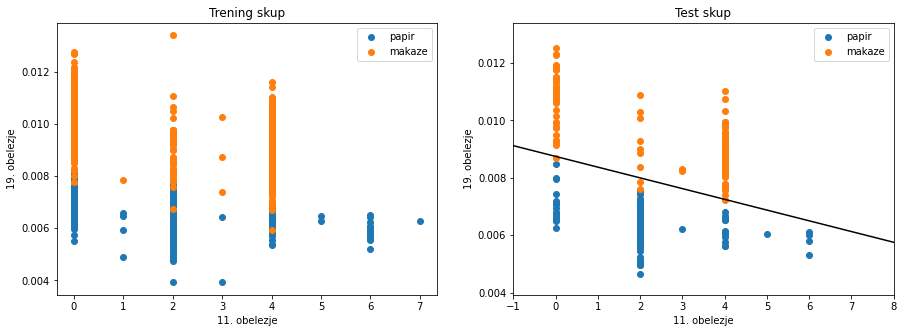

In [282]:
plt.figure(figsize=(15, 5))   

# prikaz odbiraka iz trening skupa
plt.subplot(1, 2, 1)
plt.scatter(trd[trl == 1][:,0], trd[trl == 1][:,1], label='papir')
plt.scatter(trd[trl == 2][:,0], trd[trl == 2][:,1], label='makaze')
plt.title('Trening skup'), plt.xlabel('11. obelezje'), plt.ylabel('19. obelezje'), plt.legend()

# prikaz odbiraka iz test skupa
plt.subplot(1, 2, 2)
plt.scatter(ted[tel == 1][:,0], ted[tel == 1][:,1], label='papir')
plt.scatter(ted[tel == 2][:,0], ted[tel == 2][:,1], label='makaze')
plt.title('Test skup'), plt.xlabel('11. obelezje'), plt.ylabel('19. obelezje'), plt.legend()

# prikaz kriterijumske funkciije
x = np.linspace(min(trd[:,0])-1, max(trd[:,0])+1, 100)
y = (-w_0 - w_2*x)/w_1
plt.plot(x, y, color='black')

# ogranicenja
plt.xlim(min(trd[:,0])-1, max(trd[:,0])+1)
plt.ylim(min(trd[:,1]), max(trd[:,1]))
plt.show();

Kako 11. obeležje nije kontinualnog karaktera, na graficima se teže uočava gde tačno nastaje preklapanje odbiraka. Kriterijumska funkcija (klasifikaciona prava) je prikazana na test setu na desnom grafiku. Ukoliko se rezultati uporede sa prethodno analiziranom matricom konfuzije, broj pogrešno klasifikovanih odbiraka (odbiraka sa pogrešne stane prikazane prave) je isti.